<a href="https://colab.research.google.com/github/lazuwarda/Time-Series/blob/main/TimeSeries_Sunspot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series

Nama: Naufatul Lazuwarda

ID Dicoding: Naufalazuwarda

Email: naufalazuwarda@gmail.com

Dataset: Daily Sun Spot Data (1818 to 2019)

Sumber: https://www.kaggle.com/datasets/abhinand05/daily-sun-spot-data-1818-to-2019

In [2]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/lazuwarda/Time-Series/main/sunspot_data.csv',
                 parse_dates= {"Date" : ["Year","Month","Day"]})
data

,Date,Unnamed: 0,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
0,1818-01-01,0,1818.001,-1,-1.0,0,1
1,1818-01-02,1,1818.004,-1,-1.0,0,1
2,1818-01-03,2,1818.007,-1,-1.0,0,1
3,1818-01-04,3,1818.010,-1,-1.0,0,1
4,1818-01-05,4,1818.012,-1,-1.0,0,1
...,...,...,...,...,...,...,...
73713,2019-10-27,73713,2019.821,0,0.0,34,0
73714,2019-10-28,73714,2019.823,0,0.0,34,0
73715,2019-10-29,73715,2019.826,0,0.0,30,0
73716,2019-10-30,73716,2019.829,0,0.0,24,0


In [4]:
#drop unused data
df=data.drop(columns=['Unnamed: 0','Date In Fraction Of Year','Standard Deviation','Indicator','Observations'])

In [5]:
#because of -1 give meaning missing value so change this to NaN value
df[df['Number of Sunspots'] < 0] = np.nan
df

,Date,Number of Sunspots
0,NaT,NaN
1,NaT,NaN
2,NaT,NaN
3,NaT,NaN
4,NaT,NaN
...,...,...
73713,2019-10-27,0.0
73714,2019-10-28,0.0
73715,2019-10-29,0.0
73716,2019-10-30,0.0


In [6]:
#reduce data
df=df.iloc[-50000:]

In [7]:
#check missing value
df.isnull().sum()

Date                  0
Number of Sunspots    0
dtype: int64

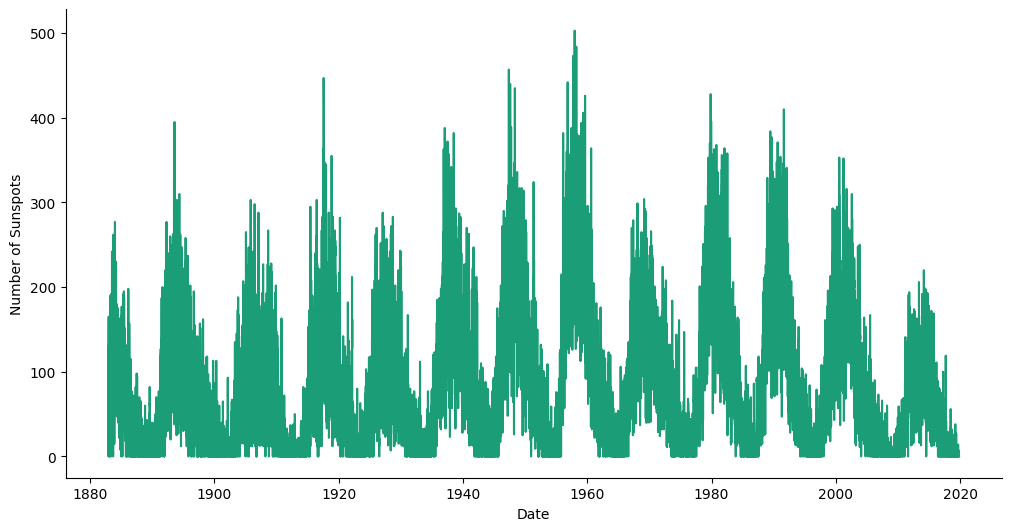

In [8]:
#make time series plot
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Number of Sunspots']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Number of Sunspots')

In [9]:
ss = df['Number of Sunspots'].values

In [10]:
ss=ss.reshape(-1,1)

In [11]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(ss)

In [12]:
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

40000 10000


In [30]:
threshold_mae = (dataset.max() - dataset.min()) * 10/100
print(threshold_mae)

0.09999999999999998


In [31]:
#Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<threshold_mae):
      print("\nMAE telah mencapai <10% data")
      self.model.stop_training = True
callbacks = myCallback()

In [32]:
def window_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [33]:
train_set = window_dataset(train, window_size=400, batch_size=1000, shuffle_buffer=4000)
test_set = window_dataset(test, window_size=400, batch_size=1000, shuffle_buffer=4000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(400, return_sequences=True),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [34]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-03, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [35]:
hist = model.fit(train_set,
                 epochs=50,
                 validation_data=test_set,
                 callbacks=[callbacks],
                 verbose=1)

Epoch 1/50
40/40 [==============================] - 52s 1s/step - loss: 0.0207 - mae: 0.1458 - val_loss: 0.0070 - val_mae: 0.0899
Epoch 2/50
40/40 [==============================] - 50s 1s/step - loss: 0.0116 - mae: 0.1154 - val_loss: 0.0069 - val_mae: 0.1000
Epoch 3/50
40/40 [==============================] - 51s 1s/step - loss: 0.0107 - mae: 0.1159 - val_loss: 0.0068 - val_mae: 0.1003
Epoch 4/50
40/40 [==============================] - 52s 1s/step - loss: 0.0103 - mae: 0.1138 - val_loss: 0.0067 - val_mae: 0.1004
Epoch 5/50
40/40 [==============================] - 51s 1s/step - loss: 0.0100 - mae: 0.1126 - val_loss: 0.0066 - val_mae: 0.0996
Epoch 6/50
40/40 [==============================] - 48s 1s/step - loss: 0.0097 - mae: 0.1112 - val_loss: 0.0064 - val_mae: 0.0982
Epoch 7/50
40/40 [==============================] - 52s 1s/step - loss: 0.0094 - mae: 0.1095 - val_loss: 0.0062 - val_mae: 0.0965
Epoch 8/50
40/40 [==============================] - 51s 1s/step - loss: 0.0091 - mae: 0.10

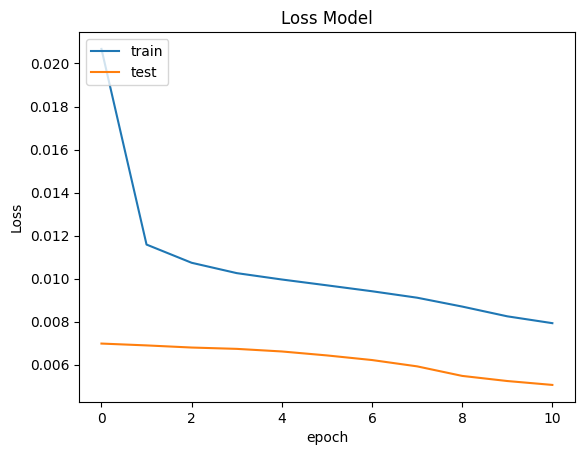

In [36]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

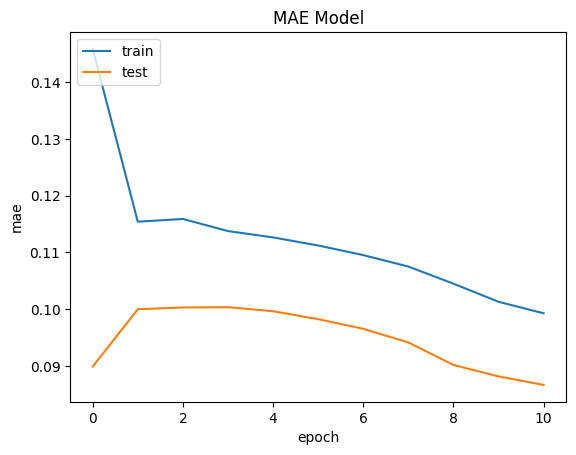

In [37]:
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()